Import everything you need — including the model class (here it's GCNConv).

In [11]:
import torch
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout # For the multi-perceptron layer
from torch_geometric.nn import GINConv  # Load graph isomorphism network
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.data import Data
from sklearn.metrics import accuracy_score, mean_squared_error

# 🔁 Load datasets
task = "regression"

train_data = torch.load(f"../4_train_test_split/random_split/{task}/{task}_train.pt")
val_data = torch.load(f"../4_train_test_split/random_split/{task}/{task}_val.pt")
test_data = torch.load(f"../4_train_test_split/random_split/{task}/{task}_test.pt")

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

# 🧱 Define Model (GIN)
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels): # where "dim_h" is dimensionality of layer; number of features or neurons that layer processes
        super(GIN, self).__init__()
        self.conv1 = GINConv( # design of the multilayer perceptron layer for the GINConv layer based on the paper (https://arxiv.org/pdf/1905.12265)
            Sequential(Linear(in_channels, hidden_channels),
                       BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU()))
        self.lin1 = Linear(hidden_channels*3, hidden_channels*3)
        self.lin2 = Linear(hidden_channels*3, out_channels)

    def forward(self, data):
        # Node embeddings
        h1 = self.conv1(data.x, data.edge_index) 
        h2 = self.conv2(h1, data.edge_index)
        h3 = self.conv3(h2, data.edge_index)

        # Graph level readout
        h1 = global_add_pool(h1, data.batch)
        h2 = global_add_pool(h2, data.batch)
        h3 = global_add_pool(h3, data.batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return h

# 🧮 Loss and evaluation setup
if task == "classification":
    num_classes = len(set([int(data.y.item()) for data in train_data]))
    model = GIN(in_channels=train_data[0].x.size(1), hidden_channels=64, out_channels=num_classes)
    criterion = torch.nn.CrossEntropyLoss()
else:
    model = GIN(in_channels=train_data[0].x.size(1), hidden_channels=64, out_channels=1)
    criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 🏋️ Training loop
def train():
    model.train()
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out.squeeze(), batch.y if task == "regression" else batch.y.long())
        loss.backward()
        optimizer.step()

# 📈 Evaluation
def evaluate(loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            preds.append(out.squeeze().cpu())
            labels.append(batch.y.cpu())
    preds = torch.cat(preds)
    labels = torch.cat(labels)

    if task == "classification":
        pred_classes = preds.argmax(dim=1)
        return accuracy_score(labels, pred_classes)
    else:
        return mean_squared_error(labels, preds)

# 🚀 Run training
for epoch in range(1, 101):
    train()
    metric = evaluate(val_loader)
    print(f"Epoch {epoch:03d} - {'Accuracy' if task == 'classification' else 'MSE'}: {metric:.4f}")

# ✅ Final test evaluation
test_metric = evaluate(test_loader)
print(f"\n🧪 Test {'Accuracy' if task == 'classification' else 'MSE'}: {test_metric:.4f}")


Epoch 001 - MSE: 9.5519
Epoch 002 - MSE: 2.4112
Epoch 003 - MSE: 1.1062
Epoch 004 - MSE: 0.8706
Epoch 005 - MSE: 0.6663
Epoch 006 - MSE: 0.7226
Epoch 007 - MSE: 0.7310
Epoch 008 - MSE: 0.9395
Epoch 009 - MSE: 0.7125
Epoch 010 - MSE: 0.6565
Epoch 011 - MSE: 0.5921
Epoch 012 - MSE: 0.6262
Epoch 013 - MSE: 0.6864
Epoch 014 - MSE: 0.7588
Epoch 015 - MSE: 0.6942
Epoch 016 - MSE: 0.9148
Epoch 017 - MSE: 0.9238
Epoch 018 - MSE: 1.2372
Epoch 019 - MSE: 0.7566
Epoch 020 - MSE: 0.6458
Epoch 021 - MSE: 0.9278
Epoch 022 - MSE: 0.6632
Epoch 023 - MSE: 0.6867
Epoch 024 - MSE: 0.6701
Epoch 025 - MSE: 0.7854
Epoch 026 - MSE: 0.7719
Epoch 027 - MSE: 0.5140
Epoch 028 - MSE: 0.8527
Epoch 029 - MSE: 1.0531
Epoch 030 - MSE: 0.7883
Epoch 031 - MSE: 0.6724
Epoch 032 - MSE: 0.8271
Epoch 033 - MSE: 0.6665
Epoch 034 - MSE: 0.7175
Epoch 035 - MSE: 0.7104
Epoch 036 - MSE: 0.9889
Epoch 037 - MSE: 0.9845
Epoch 038 - MSE: 0.7090
Epoch 039 - MSE: 0.9993
Epoch 040 - MSE: 0.8215
Epoch 041 - MSE: 0.8930
Epoch 042 - MSE:

load the graph datasets  (the random split .pt files ) and specify what task you are doing

In [12]:
task = "classification"

train_data = torch.load(f"../4_train_test_split/random_split/{task}/{task}_train.pt")
val_data = torch.load(f"../4_train_test_split/random_split/{task}/{task}_val.pt")
test_data = torch.load(f"../4_train_test_split/random_split/{task}/{task}_test.pt")

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

Define the model you want to use (GCN or MPNN or GraphSAGE, etc.)

In [13]:
# 🧱 Define Model (GIN)
class GIN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels): # where "dim_h" is dimensionality of layer; number of features or neurons that layer processes
        super(GIN, self).__init__()
        self.conv1 = GINConv( # design of the multilayer perceptron layer for the GINConv layer based on the paper (https://arxiv.org/pdf/1905.12265)
            Sequential(Linear(in_channels, hidden_channels),
                       BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU()))
        self.lin1 = Linear(hidden_channels*3, hidden_channels*3)
        self.lin2 = Linear(hidden_channels*3, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        # Node embeddings
        h1 = self.conv1(x, edge_index) 
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph level readout
        h1 = global_add_pool(h1, batch) 
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)

        return h

setup loss and evaluation 

In [14]:
if task == "classification":
    num_classes = len(set([int(data.y.item()) for data in train_data]))
    model = GIN(in_channels=train_data[0].x.size(1), hidden_channels=64, out_channels=num_classes)
    criterion = torch.nn.CrossEntropyLoss()
else:
    model = GIN(in_channels=train_data[0].x.size(1), hidden_channels=64, out_channels=1)
    criterion = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 🏋️ Training loop
def train():
    model.train()
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out.squeeze(), batch.y if task == "regression" else batch.y.long())
        loss.backward()
        optimizer.step()

# 📈 Evaluation
def evaluate(loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            preds.append(out.squeeze().cpu())
            labels.append(batch.y.cpu())
    preds = torch.cat(preds)
    labels = torch.cat(labels)

    if task == "classification":
        pred_classes = preds.argmax(dim=1)
        return accuracy_score(labels, pred_classes)
    else:
        return mean_squared_error(labels, preds)


🚀 Model training

In [15]:
for epoch in range(1, 101):
    train()
    metric = evaluate(val_loader)
    print(f"Epoch {epoch:03d} - {'Accuracy' if task == 'classification' else 'MSE'}: {metric:.4f}")

# ✅ Final test evaluation
test_metric = evaluate(test_loader)
print(f"\n🧪 Test {'Accuracy' if task == 'classification' else 'MSE'}: {test_metric:.4f}")

Epoch 001 - Accuracy: 0.5000
Epoch 002 - Accuracy: 0.7115
Epoch 003 - Accuracy: 0.6538
Epoch 004 - Accuracy: 0.7115
Epoch 005 - Accuracy: 0.6923
Epoch 006 - Accuracy: 0.7308
Epoch 007 - Accuracy: 0.7500
Epoch 008 - Accuracy: 0.7885
Epoch 009 - Accuracy: 0.7115
Epoch 010 - Accuracy: 0.7308
Epoch 011 - Accuracy: 0.7500
Epoch 012 - Accuracy: 0.6923
Epoch 013 - Accuracy: 0.6346
Epoch 014 - Accuracy: 0.6346
Epoch 015 - Accuracy: 0.7308
Epoch 016 - Accuracy: 0.7308
Epoch 017 - Accuracy: 0.6538
Epoch 018 - Accuracy: 0.7692
Epoch 019 - Accuracy: 0.6923
Epoch 020 - Accuracy: 0.7308
Epoch 021 - Accuracy: 0.7115
Epoch 022 - Accuracy: 0.7308
Epoch 023 - Accuracy: 0.6923
Epoch 024 - Accuracy: 0.6923
Epoch 025 - Accuracy: 0.7692
Epoch 026 - Accuracy: 0.6731
Epoch 027 - Accuracy: 0.7500
Epoch 028 - Accuracy: 0.6923
Epoch 029 - Accuracy: 0.6154
Epoch 030 - Accuracy: 0.7308
Epoch 031 - Accuracy: 0.6923
Epoch 032 - Accuracy: 0.5769
Epoch 033 - Accuracy: 0.7500
Epoch 034 - Accuracy: 0.7692
Epoch 035 - Ac

Epoch 001 - Train Accuracy: 0.8818, Val Accuracy: 0.6731
Epoch 002 - Train Accuracy: 0.8392, Val Accuracy: 0.7308
Epoch 003 - Train Accuracy: 0.8700, Val Accuracy: 0.7115
Epoch 004 - Train Accuracy: 0.8913, Val Accuracy: 0.7308
Epoch 005 - Train Accuracy: 0.8251, Val Accuracy: 0.6731
Epoch 006 - Train Accuracy: 0.8747, Val Accuracy: 0.7115
Epoch 007 - Train Accuracy: 0.9125, Val Accuracy: 0.7308
Epoch 008 - Train Accuracy: 0.9220, Val Accuracy: 0.7500
Epoch 009 - Train Accuracy: 0.9173, Val Accuracy: 0.7500
Epoch 010 - Train Accuracy: 0.8865, Val Accuracy: 0.7308
Epoch 011 - Train Accuracy: 0.9102, Val Accuracy: 0.7115
Epoch 012 - Train Accuracy: 0.8842, Val Accuracy: 0.7115
Epoch 013 - Train Accuracy: 0.8936, Val Accuracy: 0.7115
Epoch 014 - Train Accuracy: 0.8416, Val Accuracy: 0.6731
Epoch 015 - Train Accuracy: 0.8794, Val Accuracy: 0.6923
Epoch 016 - Train Accuracy: 0.8203, Val Accuracy: 0.6923
Epoch 017 - Train Accuracy: 0.9054, Val Accuracy: 0.7885
Epoch 018 - Train Accuracy: 0.9

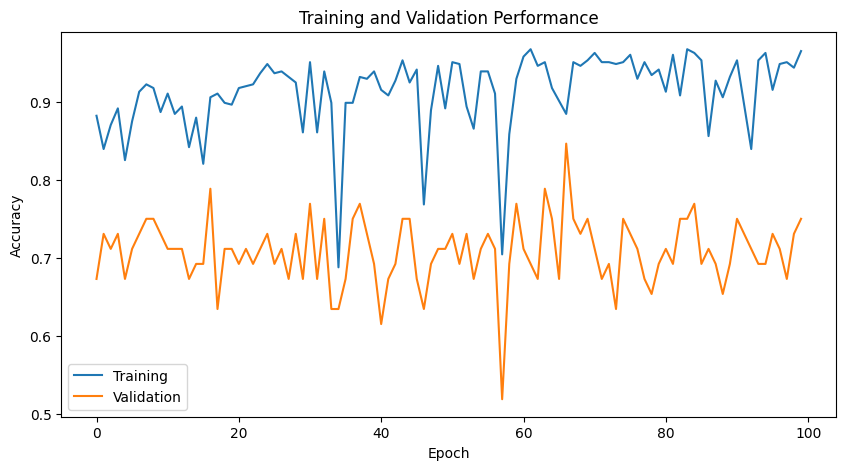

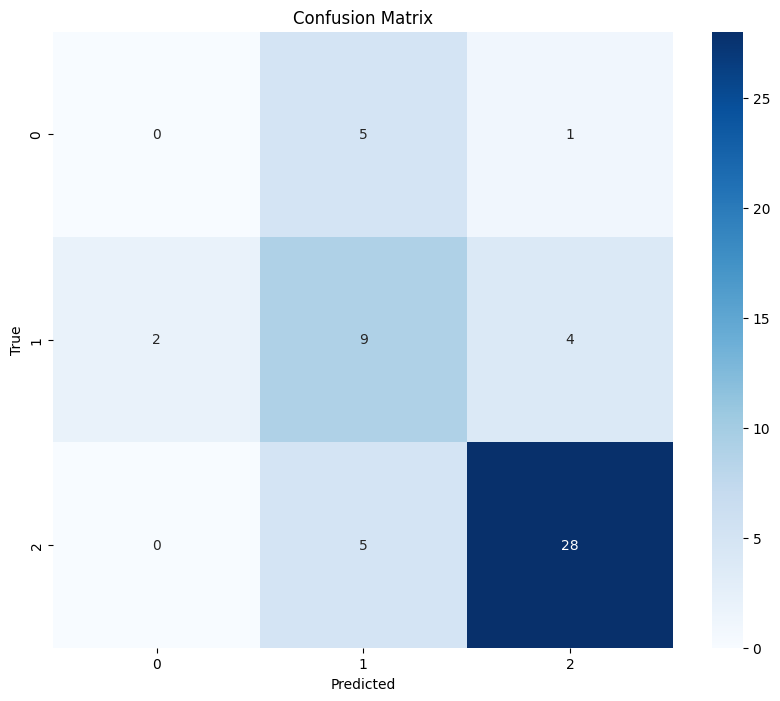

In [17]:
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Add history
train_history = []
val_history = []

# Training
for epoch in range(1, 101):
    train()
    train_metric = evaluate(train_loader)
    val_metric = evaluate(val_loader)
    train_history.append(train_metric)
    val_history.append(val_metric)
    print(f"Epoch {epoch:03d} - Train {'Accuracy' if task == 'classification' else 'MSE'}: {train_metric:.4f}, Val {'Accuracy' if task == 'classification' else 'MSE'}: {val_metric:.4f}")

# Plot training curve
plt.figure(figsize=(10, 5))
plt.plot(train_history, label='Training')
plt.plot(val_history, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy' if task == 'classification' else 'MSE')
plt.title('Training and Validation Performance')
plt.legend()
plt.show() 

# Plot confusion matrix 
if task == "classification":
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()